# Notes



### Import Libraries

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skewnorm, truncnorm, poisson

Detect Community
https://networkx.org/documentation/stable/reference/algorithms/community.html

### Helper Functions for Graph Class

In [ ]:
#Helper functions
def prune(G):
        isolate = []

        for i in G.nodes:
            if len(nx.node_connected_component(G, i)) < int(len(G.nodes)/3):
                isolate.append(i)
        G.remove_nodes_from(isolate)
        return G

#Get mean sentiment of a graph
def getSentimentStatistics(graph):
    sentiment = []
    for i in graph.G.nodes:
        sentiment.append(graph.G.nodes[i]["sentiment"])

    return np.mean(sentiment), np.std(sentiment)


### Graph Class

In [ ]:
#Graph class
class Graph:
    
    #Create a full random, guassian distributed, graph
    def createRandomGraph(self, numNodes, meanClusterSize, clusterVariance, probIntraConnection, probInterConnection, meanSkew = 0, random = False):
        G = nx.gaussian_random_partition_graph(numNodes, meanClusterSize, clusterVariance, probIntraConnection, probInterConnection, directed = False)
        G = prune(G)
        self.G = G
        self.initSentiment(meanSkew, random)
        self.initReplies(random)
    
    #Create Graph with single comment
    def createRandomComment(self, meanSkew, random = False):
        G = nx.Graph()
        self.G = G
        self.G.add_node(0)
        self.initSentiment(meanSkew, random = False)
    
    #Initialize sentiment in the graph
    def initSentiment(self, meanSkew, random = False):
        numNodes = len(self.G.nodes)

        if random:
            weights = np.round(np.random.uniform(low = -1, high = 1, size = numNodes),4)
        else:
            weights = np.round(truncnorm.rvs(-1 - meanSkew, 1 - meanSkew, loc = meanSkew, size = numNodes),4)
           
        j = 0
        for i in self.G.nodes:
            self.G.nodes[i]["sentiment"] = weights[j]
            j +=1
            
    #Initialize edge wieghts in the graph
    def initReplies(self, random = False):
        numEdges = len(self.G.edges)

        if random:
            weights = np.random.randint(low=1,high = 10, size = numEdges)
            j = 0
            for u,v in self.G.edges:
                self.G[u][v]["replies"] = weights[j]
                j += 1
        else:
            for u,v in self.G.edges:
                self.G[u][v]["replies"] = np.random.randint(low= 1,high = 2*len([n for n in self.G.neighbors(u)]))
                
    #add commenter (node) to graph        
    def addCommenter(self, meanSkew = 0, random = False, propagate = False, threshold = 0, variable = True):
        index = len(self.G.nodes)+1
        self.G.add_node(index)
        
        if random:
            self.G.nodes[index]["sentiment"] = np.round(np.random.uniform(low = -1, high = 1),4)
        else:
            self.G.nodes[index]["sentiment"] = np.round(truncnorm.rvs(-1 - meanSkew, 1 - meanSkew, loc = meanSkew),4)
            
        connection = np.random.choice(list(self.G.nodes)[:-1])
        self.G.add_edge(index,connection)
        self.G[index][connection]["replies"] = 1
        
        if propagate:
            self.propagateSentiment(connection, index, threshold, variable)
        
    #add reply (edge) to graph or add +1 to exisiting edge
    def addReply(self, random = False, propagate = False, threshold = 0, variable = True):
        if random:
            probability = None
        else:
            probability = []
            for u in self.G.nodes:
                probability.append(len([n for n in self.G.neighbors(u)]))
                
            probability = np.array(probability)/sum(probability)
        
        if len(self.G.nodes) > 2:
            commenters = np.random.choice(list(self.G.nodes),2,replace=False, p = probability)
        else:
            commenters = list(self.G.nodes)
        
        if self.G.has_edge(commenters[0],commenters[1]):
            self.G[commenters[0]][commenters[1]]["replies"] += 1
        else:
            self.G.add_edge(commenters[0],commenters[1])
            self.G[commenters[0]][commenters[1]]["replies"] = 1
            
        if propagate:
            self.propagateSentiment(commenters[0],commenters[1], threshold, variable)
            
    #Propgate sentiment from one node to another node1 -> node2
    def propagateSentiment(self, node1, node2, threshold = 0, variable = True):
        weight = 1/(self.G[node1][node2]["replies"] + 1)
        
        if variable:
            threshold *= 1/(self.G[node1][node2]["replies"])
        
        if np.random.uniform() > threshold:
             self.G.nodes[node2]["sentiment"] = np.round((weight*self.G.nodes[node2]["sentiment"] + (1-weight)*self.G.nodes[node1]["sentiment"]),4)
                
    #Propagate sentiment between two random connected nodes in graph
    def propagateSentimentRandom(self, threshold = 0, variable = True):
        edge = list(self.G.edges)[np.random.randint(0,len(self.G.edges))]
        
        if np.random.uniform() > .5:
            self.propagateSentiment(edge[0], edge[1], threshold, variable)
        else:
            self.propagateSentiment(edge[1], edge[0], threshold, variable)
    
    #plot out graph
    def plotGraph(self, showColor = True, showSentiment = True, showReplies = True):
        sentiments = None
        replies = None
        color = None
        cmap = None
        labels = False
        
        if showSentiment:
            sentiments = dict(self.G.nodes(data="sentiment"))
            labels = True
            
        if showColor:
            color = list(dict(self.G.nodes(data="sentiment")).values())
            cmap='RdYlGn'   
        pos=nx.kamada_kawai_layout(self.G)
        
        if showReplies:
            replies = nx.get_edge_attributes(self.G,'replies')
            nx.draw_networkx_edge_labels(self.G,pos,edge_labels=replies)
    
        nx.draw(self.G,labels = sentiments, with_labels = labels, node_color = color, cmap=cmap, pos = pos)
       
        

# Simulate Sentiment Graphs

### Constructing our own graph

First we will use all of the functions in the Graph class to consturct our own graph. The functions we will be using are:

#### {createRandomComment} <br>

Will seed graph with a comment of sentiment drawn from a skewed normal distribution.<br>
Arguement 'meanSkew' will choose the mean of the skewed normal distribution the sentiment is draw from with 0 being a typical random normal distribution. <br>
Arguement 'random' is a boolean arguement that will switch on/off a random uniform distribution. <br>


#### {addCommenter} <br>

Will add a new node (commenter) to the graph. The connecting edge (reply) will be made to a random existing node in the graph. The new commenter will also have a sentiment that can be controled with the same arguements as 'createRandomComment'. <br>


#### {addReply} <br>

Will add a new edge (reply) between two existing unconnected nodes OR add +1 to the weight of an existing connection. <br>
Arguement 'random' is a boolean that will determine if the new connection is made randomly, else the new connection will be made based on a weighted probability that weights the most central (active) members heavier. This is based on the assumption that more active members will be making more replies. <br>

Arguments 'progagate', 'threshold', and 'variable' will be explained in the next section.


#### {plotGraph} <br>

Will plot out the constructed graph, following matplotlib figure specifications. <br>
Arguements 'showColor', 'showSentiment', and 'showReplies' are all booleans that will toggle on/off their perspective graphical features. <br>
'showColor' = color code nodes based on sentiment value <br>
'showSentiment' = label each node with its sentiment value <br>
'showReplies' = lable each edge with # of replies nodes have made to each other

Arguments 'progagate', 'threshold', and 'variable' will be explained in the next section.

### See Example of these Fuctions Below

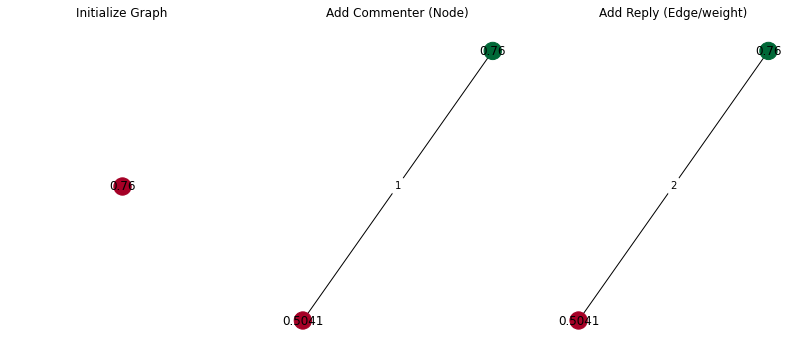

In [2]:
#initialize graph
graph = Graph()
graph.createRandomComment(0)

plt.figure(figsize = (14,6))
plt.subplot(1,3,1)
plt.title("Initialize Graph")
graph.plotGraph()

#add commenter
plt.subplot(1,3,2)
plt.title("Add Commenter (Node)")
graph.addCommenter(0)
graph.plotGraph()

#add reply
plt.subplot(1,3,3)
plt.title("Add Reply (Edge/weight)")
graph.addReply()
graph.plotGraph()



### Propagate Sentiment

To run our simulation we must progate sentiment throughout our graph. To do this we use the following functions:

#### {propagateSentiment} <br>
'propagateSentiment' will choose 2 connected nodes and propagate the sentiment of node1 to node2. It will do this by setting the sentiment of node2 equal to the weighted mean of the sentiment form node1 and node2. The mean is weighted by the number of replies between commenters (weight of edge between nodes) with the following rule: <br>

weight = 1/# of replies + 1 <br>
node2 senteiment = weight * node2 senteiment + (1-weight)* node1 senteiment <br>

Arguments 'node1' and 'node2' are the starting and ending nodes of propagation (node1 -> node2) <br>
Arguement 'threshold' allows for the a resistance value to be added between 0 and 1, where the higher the value, the less likely a node is to adopt the propagated sentiment <br>
Arguement 'variable' is a boolean that sets the threshold value to be variable depending on the # of replies between 2 commenters. The resistance threshold will be divided by the # of replies making highly connected nodes more vunerable to adopting the sentiment propogated to them. <br>


#### {propagateSentimentRandom}  <br>

Selects two random connected nodes in the graph and propogates sentiment from one to the other. Takes in arguements 'threshold' and 'variable' as seen above. <br>

#### {addReply} <br>

Argument 'propagate' is a boolean that will toggle a call to 'propogateSentiment' after the new edge is created, meaning if a reply is made sentiment will be progated - modified by the arguments given in 'propagateSentiment'. <br>

#### {addCommenter}

Argument 'propagate' is a boolean that will toggle a call to 'propogateSentiment' after the new edge is created, meaning if a reply is made sentiment will be progated - modified by the arguments given in 'propagateSentiment'. <br>

### See Example of these Fuctions Below

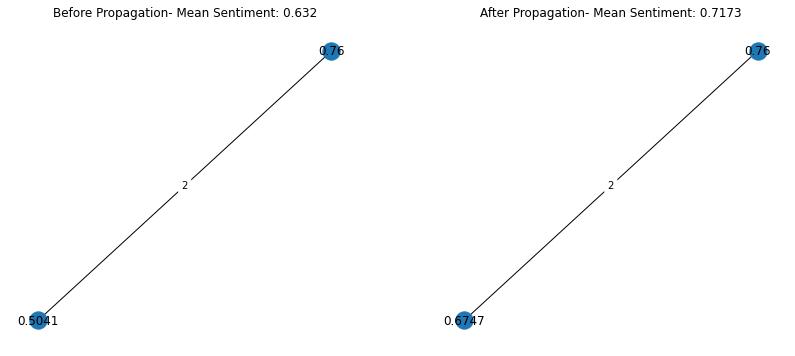

In [3]:
plt.figure(figsize = (14,6))

plt.subplot(1,2,1)
plt.title("Before Propagation- " + "Mean Sentiment: " + str(np.round(getSentimentStatistics(graph)[0],4)))
graph.plotGraph(showColor = False)

plt.subplot(1,2,2)
graph.propagateSentimentRandom()
plt.title("After Propagation- " + "Mean Sentiment: " + str(np.round(getSentimentStatistics(graph)[0],4)))
graph.plotGraph(showColor = False)



### Creating Larger Graphs

Let's put all of our components together and create a large graph.

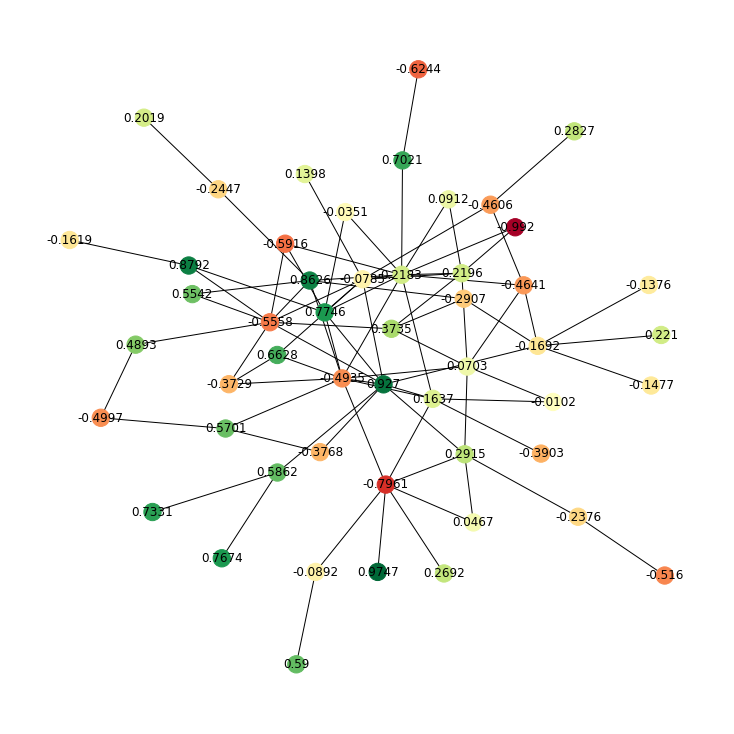

In [4]:
#initialize graph
graph = Graph()
graph.createRandomComment(0)

#add 50 nodes and 50 more edges
for i in range(0,50):
    graph.addCommenter(0)
    if i > 0:
        graph.addReply()
    
plt.figure(figsize = (10,10))
graph.plotGraph(showReplies = False)


### Propagate Sentiment Through the Graph

Now let's propagate sentiment through our graph.

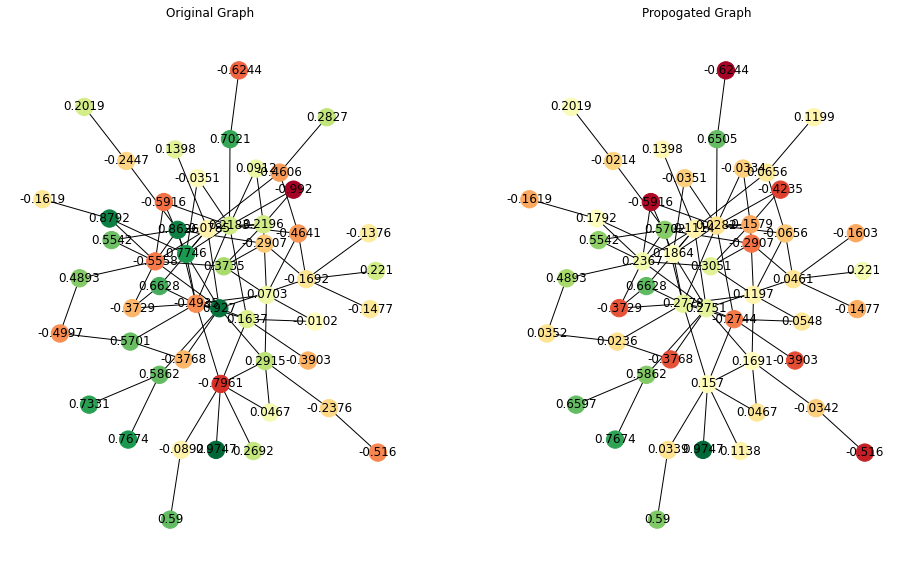

In [5]:
plt.figure(figsize = (16,10))
plt.subplot(1,2,1)
plt.title("Original Graph")
graph.plotGraph(showReplies = False)


#propagate sentiment between 100 nodes
meanSentiment = []
for i in range(0,50):
    graph.propagateSentimentRandom()
    meanSentiment.append(getSentimentStatistics(graph)[0])

plt.subplot(1,2,2)
plt.title("Propogated Graph")
graph.plotGraph(showReplies = False)


### Quick Graph Creation

If we wish to not make our own graphs "by hand" we can leverage some of networkX's built in tools. Speficially, we can use "nx.gaussian_random_partition_graph" to create a random graph for us with sepecified parameters. <br>

See Documentation: https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.gaussian_random_partition_graph.html

in short, networkX is creating a random graph that clusters off of a guassian distribution. A user can define the number of nodes in the graph, the mean clustering off the nodes, the variance is the clustering of the nodes, the node dispersion and the probably of intra and inter cluster edges <br>

After networkX creates the graph, custom functions {initSentiment} and {initReplies} will add sentiment and edge weights to the graph. <br>

### {createRandomGraph}  <br>
Calls 'nx.gaussian_random_partition_graph' and gives needed arguements, see documentation above. Also calls {initSentiment} and {initReplies}.


### {initSentiment}  <br>
Adds a sentiment value into an already consturcted graph. Pulls sentiment values from a random distribution is 'random' is true, else sentiment values are pulled from a skewed normal distribution with mean 'meanSkew'.


### {initReplies}  <br>
Adds edge weights to an already constructed graph. Adds random weights if 'random' is true, else weights edge value by the centrality of the starting node.


### See example below

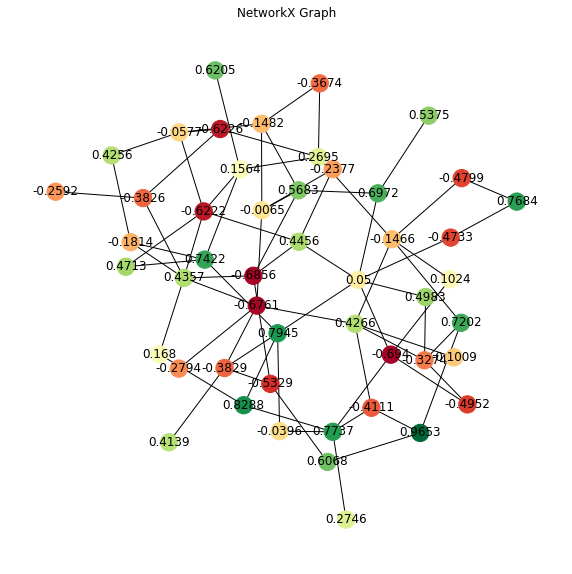

In [6]:
graph = Graph()
graph.createRandomGraph(50,10,2,.1,.05)

plt.figure(figsize = (10,10))
plt.title("NetworkX Graph")
graph.plotGraph(showReplies = False)

## Sample Study - A Toxic Community

Let us model a scenerio of people joining a pre-existing, tightly knit community with very negative sentiment. 

We will assume:
1. People just entering the community will have a random sentiment
2. People just entering the community will have a resistance threshold of .5
3. Sentiment will be propgated by replies 

### Step 1

We first use networkX to create a tightly connected toxic community. <br>
**note the coloring will be missleading at first because of the relative scale**


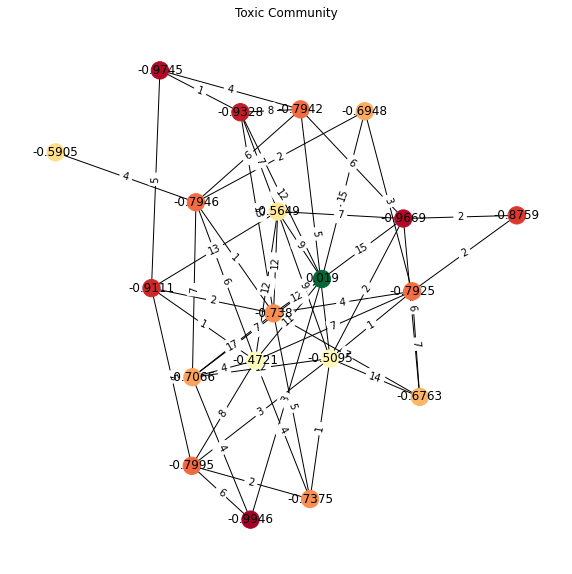

In [7]:
graph = Graph()
graph.createRandomGraph(20,1,1,.3,.3, meanSkew = -4)

plt.figure(figsize = (10,10))
plt.title("Toxic Community")
graph.plotGraph()

### Step 2

We will now start adding people from outside off the community. We will add 30 nodes and 60 replies, observing the sentiment statistics. 

In [8]:
meanSentiment = []
stdSentiment = []

for i in range(0,30):
    graph.addCommenter(0, random = True, propagate = True, threshold = .5, variable = True)
    meanSentiment.append(getSentimentStatistics(graph)[0])
    stdSentiment.append(getSentimentStatistics(graph)[1])

for i in range(0,60):
    graph.addReply(propagate = True, threshold = .5, variable = True)
    meanSentiment.append(getSentimentStatistics(graph)[0])
    stdSentiment.append(getSentimentStatistics(graph)[1])
    

Text(0, 0.5, 'Standard Deviation')

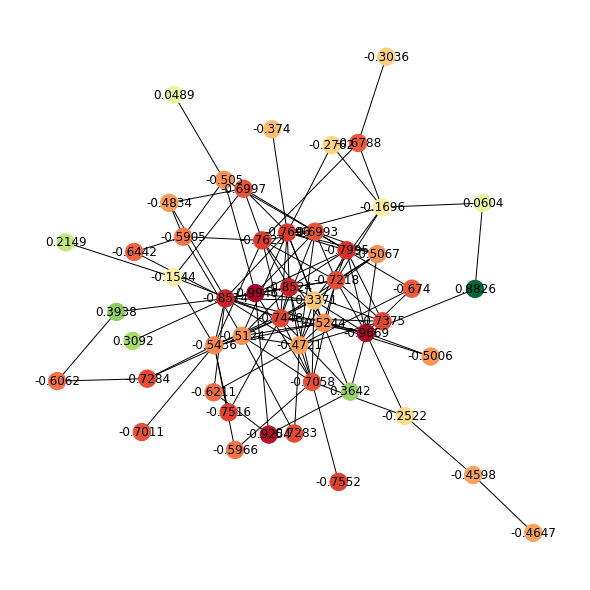

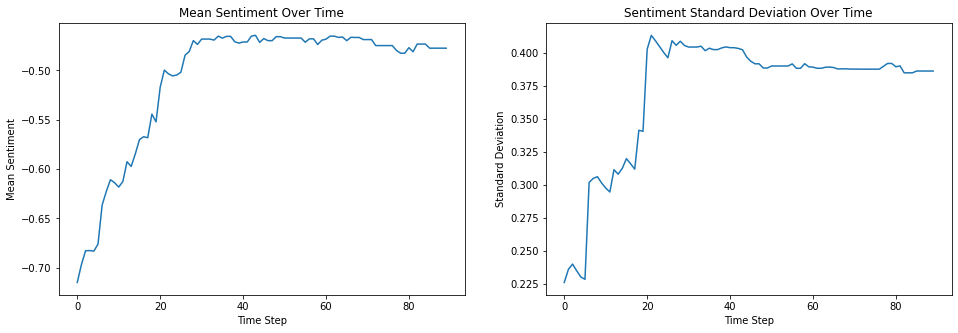

In [9]:
plt.figure(figsize = (8,8))
graph.plotGraph(showReplies = False)

plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
t = np.arange(0,len(meanSentiment))
plt.plot(t,meanSentiment)
plt.title("Mean Sentiment Over Time")
plt.xlabel("Time Step")
plt.ylabel("Mean Sentiment")

plt.subplot(1,2,2)
plt.plot(t,stdSentiment)
plt.title("Sentiment Standard Deviation Over Time")
plt.xlabel("Time Step")
plt.ylabel("Standard Deviation")

### Observations

initially, commenters swing the graph's sentiment towards their's (we would expect the graph to head towards a sentiment of 0 since we added random sentiments), but as the new commentors start to interact, the sentiment swings back. This can be see in the mean and especially the standard deviation as we see both regress to a balance betwee the original nodes and new nodes. 